In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math

In [2]:
#DETECTIONS
sn19rwd = pd.read_csv('./19rwd/detections.csv')
sn21gno = pd.read_csv('./21gno/detections.csv')
sn21heh = pd.read_csv('./21heh/detections.csv')
sn21vgn = pd.read_csv('./21vgn/detections.csv')
sn22hnt = pd.read_csv('./22hnt/detections.csv')
sn22jpx = pd.read_csv('./22jpx/detections.csv')

print(sn21vgn.columns)

#NON DETECTIONS 
sn19rwd_non = pd.read_csv('./19rwd/non_detections.csv')
sn21gno_non = pd.read_csv('./21gno/non_detections.csv')
sn21heh_non = pd.read_csv('./21heh/non_detections.csv')
sn21vgn_non = pd.read_csv('./21vgn/non_detections.csv')
sn22hnt_non = pd.read_csv('./22hnt/non_detections.csv')
sn22jpx_non = pd.read_csv('./22jpx/non_detections.csv')

print(sn21vgn_non.columns)

Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')
Index(['tid', 'mjd', 'fid', 'diffmaglim'], dtype='object')


In [3]:
#plotting routine
#goal: plot and find the LC points that are the decline of the 1st peak

def plot_LC(df, df_non, ID='SN ID',show=True):
    """
    input: df = DataFrame from detections.csv, ID = str of SN name
    output: individual plot of SN LC in g and r band
    """
    plt.figure(figsize=(7,5))
    plt.rcParams.update({'font.size': 15})
    
    #plot g band w/ err
    plt.scatter(df[df['fid']==1].mjd,df[df['fid']==1].magpsf, color='green', label='ztf g') #detections
    plt.errorbar(df[df['fid']==1].mjd,df[df['fid']==1].magpsf,df[df['fid']==1].sigmapsf, fmt='o',color='green', label='')
#     plt.scatter(np.array(df_non[df_non['fid']==1].mjd),np.array(df_non[df_non['fid']==1].diffmaglim), color='green', label='', marker='v', alpha=0.3)
    
    #plot r band w/ err
    plt.scatter(df[df['fid']==2].mjd,df[df['fid']==2].magpsf, color='red', label='ztf r') #detections
    plt.errorbar(df[df['fid']==2].mjd,df[df['fid']==2].magpsf,df[df['fid']==2].sigmapsf, fmt='o',color='red', label='')
#     plt.scatter(np.array(df_non[df_non['fid']==2].mjd),np.array(df_non[df_non['fid']==2].diffmaglim), color='red', label='', marker='v', alpha=0.3)

    plt.title(ID)
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.gca().invert_yaxis()
    if show:
        plt.show()
    return

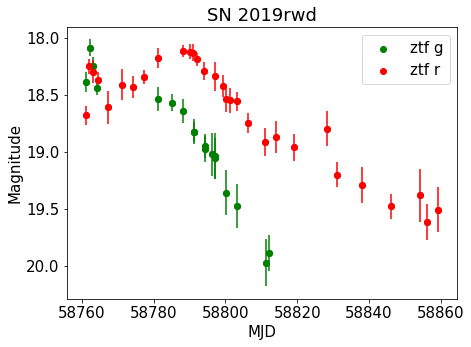

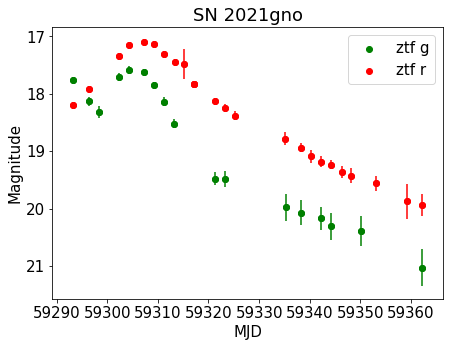

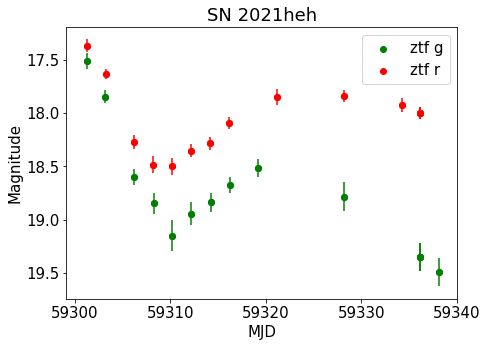

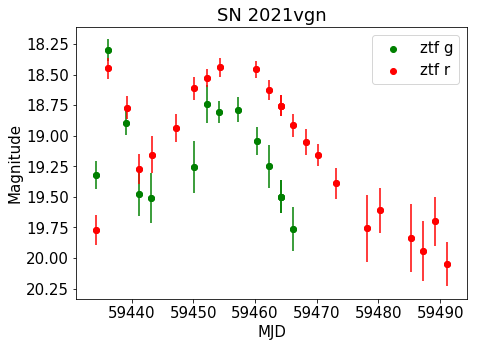

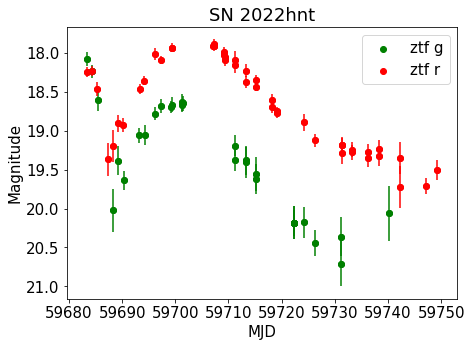

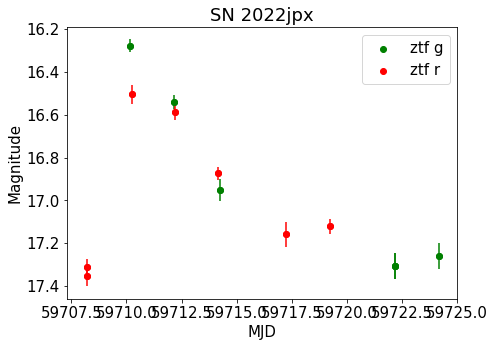

In [4]:
sn_df_list = [sn19rwd, sn21gno, sn21heh, sn21vgn, sn22hnt, sn22jpx]
sn_df_non_list = [sn19rwd_non, sn21gno_non, sn21heh_non, sn21vgn_non, sn22hnt_non, sn22jpx_non]
sn_ids = ['SN 2019rwd','SN 2021gno','SN 2021heh','SN 2021vgn','SN 2022hnt','SN 2022jpx']

for i,df in enumerate(sn_df_list):
    df_non = sn_df_non_list[i]
    plot_LC(df,df_non,ID=sn_ids[i])

In [5]:
#defining troughs (a2 param in mcmc) [g,r] for each sn

sn19rwd_a2 = [3, 4]
sn21gno_a2 = [2, 0]
sn21heh_a2 = [4, 3]
sn21vgn_a2 = [4, 3]
sn22hnt_a2 = [3, 3]
sn22jpx_a2 = [3, 5]

In [6]:
#normalizing to trough (a2)
#let's normalize (and whiten) the lightcurves to peak (a1)
#peak magnitude = 1
#max of first peak => t=0

def norm_LC_a2(df, a2=[0,0]):
    """
    input: 
        df = SN df from read in
        a2 = list of data points in form of [g_band_trough, r_band_trough]
    output:
        norm_sn_g, norm_sn_r = [time_g_band, mag_g_band], [time_r_band, mag_r_band]
        ^^ 2, 2D arrays containing normalized time and magnitude (normed to first trough, [t0, m0])
    """
    #g band normalization
    a2_g_t = np.array(df[df['fid']==1].mjd)[a2[0]]    #time
    a2_g_m = np.array(df[df['fid']==1].magpsf)[a2[0]] #mag

    norm_t_g = (df[df['fid']==1].mjd - a2_g_t)+15               #normalized time in g band
    norm_m_g = (df[df['fid']==1].magpsf - a2_g_m)              #normalized mag in g band
    norm_sn_g = [norm_t_g, norm_m_g]

    #r band normalization
    a2_r_t = np.array(df[df['fid']==2].mjd)[a2[1]]    #time
    a2_r_m = np.array(df[df['fid']==2].magpsf)[a2[1]] #mag   
    
    norm_t_r = (df[df['fid']==2].mjd - a2_r_t)+15               #normalized time in g band
    norm_m_r = (df[df['fid']==2].magpsf - a2_r_m)              #normalized mag in g band
    norm_sn_r = [norm_t_r, norm_m_r]

    if len(norm_t_g) != len(norm_m_g):
        print('ERR: uneven time and mag arrays [g band]')
    elif len(norm_t_r) != len(norm_m_r):
        print('ERR: uneven time and mag arrays [r band]')
    else:
        return norm_sn_g, norm_sn_r

In [7]:
#actually normalizing the LCs to a1
norm_sn19rwd_g_a2, norm_sn19rwd_r_a2 = norm_LC_a2(sn19rwd, sn19rwd_a2)
norm_sn21gno_g_a2, norm_sn21gno_r_a2 = norm_LC_a2(sn21gno, sn21gno_a2)
norm_sn21heh_g_a2, norm_sn21heh_r_a2 = norm_LC_a2(sn21heh, sn21heh_a2)
norm_sn21vgn_g_a2, norm_sn21vgn_r_a2 = norm_LC_a2(sn21vgn, sn21vgn_a2)
norm_sn22hnt_g_a2, norm_sn22hnt_r_a2 = norm_LC_a2(sn22hnt, sn22hnt_a2)
norm_sn22jpx_g_a2, norm_sn22jpx_r_a2 = norm_LC_a2(sn22jpx, sn22jpx_a2)

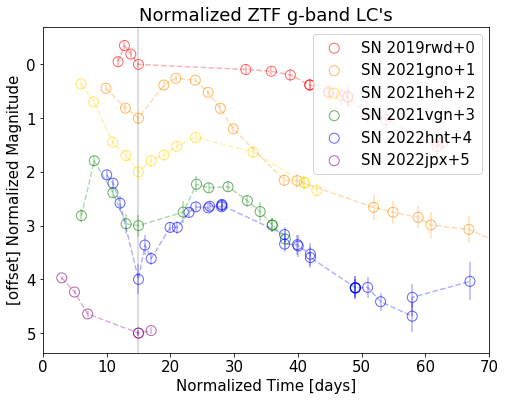

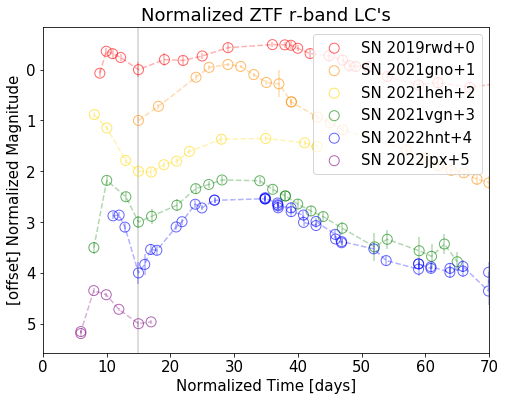

In [8]:
# PLOTTING NORMALIZED OFFSET LCs (a2 version)
norm_g_all_a2 = [norm_sn19rwd_g_a2,norm_sn21gno_g_a2,norm_sn21heh_g_a2,norm_sn21vgn_g_a2,norm_sn22hnt_g_a2,norm_sn22jpx_g_a2]
norm_r_all_a2 = [norm_sn19rwd_r_a2,norm_sn21gno_r_a2,norm_sn21heh_r_a2,norm_sn21vgn_r_a2,norm_sn22hnt_r_a2,norm_sn22jpx_r_a2]
offsets = [0,1,2,3,4,5]
colors=['red', 'darkorange', 'gold', 'green', 'blue', 'purple']

#making plot of g band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_g_all_a2):
    plt.scatter(sn[0], sn[1]+offsets[i], facecolors='None', edgecolors=colors[i], s=100, alpha=0.6, label=sn_ids[i]+'+'+str(offsets[i])) # normalized points
    df = sn_df_list[i]
    plt.errorbar(sn[0], sn[1]+offsets[i],df[df['fid']==1].sigmapsf, c=colors[i], linestyle='--', alpha=0.3, label='')
    
plt.axvline(15, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF g-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('[offset] Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_a2_g_offset.png')


#mkaing plot of r band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_r_all_a2):
    if type(sn) != str:
        plt.scatter(sn[0], sn[1]+offsets[i], facecolors='none', edgecolors=colors[i], s=100, alpha=0.6, label=sn_ids[i]+'+'+str(offsets[i])) # normalized points
        df = sn_df_list[i]
        plt.errorbar(sn[0], sn[1]+offsets[i], df[df['fid']==2].sigmapsf, c=colors[i], linestyle='--', alpha=0.3, label='')
    
plt.axvline(15, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF r-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('[offset] Normalized Magnitude')
plt.legend(loc='upper right')
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_LCs_a2_r_offset.png')

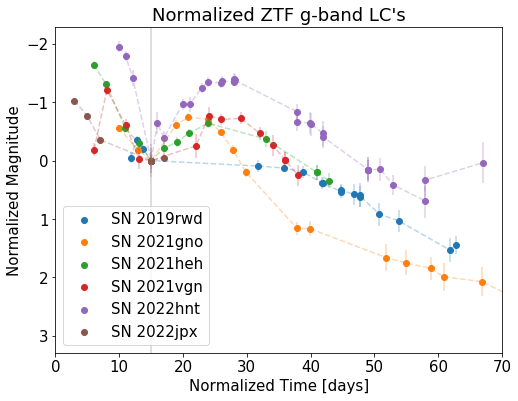

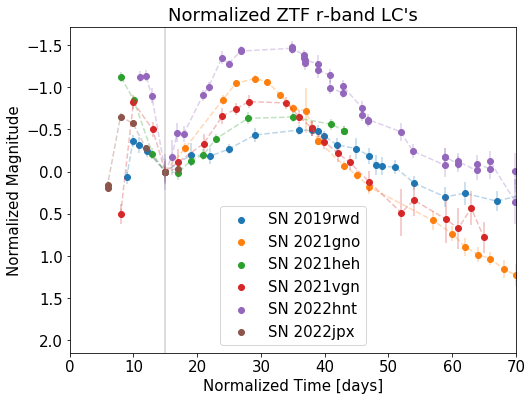

In [9]:
#NON OFFSET NORMALIZED PLOT

#making plot of g band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_g_all_a2):
    plt.scatter(sn[0], sn[1], label=sn_ids[i]) # normalized points
    df = sn_df_list[i]
    plt.errorbar(sn[0], sn[1], df[df['fid']==1].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(15, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF g-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_a2_LCs_g.png')

#mkaing plot of r band
plt.figure(figsize=(8,6))
for i,sn in enumerate(norm_r_all_a2):
    if type(sn) != str:
        plt.scatter(sn[0], sn[1], label=sn_ids[i]) # normalized points
        df = sn_df_list[i]
        plt.errorbar(sn[0], sn[1], df[df['fid']==2].sigmapsf, linestyle='--', alpha=0.3, label='')
    
plt.axvline(15, linestyle='-', color='lightgray', zorder=0)
plt.title('Normalized ZTF r-band LC\'s')
plt.xlabel('Normalized Time [days]')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim(0, 70)
# plt.ylim(-1.5, 2.5)
plt.gca().invert_yaxis()
plt.savefig('./figures/normalized_a2_LCs_r.png')

In [10]:
#####################################################
#
#          all at once lightning model
#
#####################################################

In [11]:
#defining lines/liklihoods to be called in MCMC fitting
def model(theta, x, r1=True):
    if r1:
        m1, m2, m3, b2, a1, a2, log_f = theta

        if x<= a1:
            model = m1*x + (a1*(m2-m1)+b2)    
        elif a1< x <= a2:
            model = m2*x + b2
        elif a2 < x:
            model = (m3*x) + (a2*(m2-m3)+b2)
        else:
            print("smthn wrong") 
    else:
        m2, m3, b2, a1, a2, log_f = theta
        if x<=a1:
            print("out of bounds")
        elif a1< x <= a2:
            model = m2*x + b2
        elif a2 < x:
            model = (m3*x) + (a2*(m2-m3)+b2)
        else:
            print("smthn wrong") 
    return model
    

def log_likelihood(theta, x, y, yerr, r1=True):
    if r1:
        m1, m2, m3, b2, a1, a2, log_f = theta
        model_all = np.array([model(theta, v) for v in x])
        sigma2 = yerr**2 + model_all**2 * np.exp(2 * log_f)
    else:
        m2, m3, b2, a1, a2, log_f = theta
        model_all = np.array([model(theta, v, False) for v in x])
        sigma2 = yerr**2 + model_all**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model_all) ** 2 / sigma2 + np.log(sigma2))

def log_prior_combo(theta, r1=True): 
    if r1:
        m1, m2, m3, b2, a1, a2, log_f = theta
        if -5.0<m1<=0.0 and 0.0<=m2<5.0 and -5.0<m3<=0.0 and -7.0<b2<=0.0 and 0.0<a1<14.0 and 10.0<a2<20.0 and -4.0<log_f<4.0:
            return 0.0
        return -np.inf
    else:
        m2, m3, b2, a1, a2, log_f = theta
        if 0.0<=m2<5.0 and -5.0<m3<=0.0 and -7.0<b2<=0.0 and 0.0<a1<=14.0 and 10.0<a2<20.0 and -4.0<log_f<4.0:
            return 0.0
        return -np.inf

def log_probability_combo(theta, x, y, yerr, r1=True):
    if r1:
        lp = log_prior_combo(theta)
    else:
        lp = log_prior_combo(theta,r1=False)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, r1)

In [12]:
# input: x, y, yerr, [m0,b0,logf0], rise/fall, 
# output: [[m,ml,mu],[b,bl,bu],[logf,logfl,logfu]], best_fit_model[N,2]

def mcmc_fit(x, y, yerr, p0=[-1,1,-1,-3,8,15,-2], r1=True):
    np.random.seed(42)

    if r1:
        pos = p0 + 1e-4 * np.random.randn(64, 7)
        nwalkers, ndim = pos.shape
    else:
        pos = p0[1:] + 1e-4 * np.random.randn(128, 6)
        nwalkers, ndim = pos.shape

    #actually doing MCMC
    if r1:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability_combo, args=(x, y, yerr))
    else:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability_combo, args=(x, y, yerr, False))
    sampler.run_mcmc(pos, 7500, progress=True);
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    mcmc_results =[]
    #retrieve the 16th/50th/84th percentile for m,b,log_f and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)
    
    return mcmc_results, sampler

In [13]:
# FIXED DAY SUBSELECTION FROM LCs
def subselect(df, norm_sne=['norm_sn_g_ls','norm_sn_r_ls'], a2=[3,3]):
    """
    input: 
        df = sne dataframe (when data first read in)
        norm_sne = list of [g,r] band data w/ each being a 2D list of pandas.Series, (time, mag)
        a2 = list of data point index for a2 in form of [g_band_trough, r_band_trough]
    output:
        [sub_g_t, sub_g_m, sub_g_e], [sub_r_t, sub_r_m, sub_r_e] = 2 lists [gband, rband] of [time,mag,magerr] arrays 
                                                                    with shape=(N) where N = number of data points 
                                                                    before t=20
    """
    norm_sne_g = norm_sne[0]
    norm_sne_r = norm_sne[1]
    
    #index of trough in each band
    a2_g = a2[0]
    a2_r = a2[1]
    
    # G_BAND ########################################
    norm_sn_g_t = np.array(norm_sne_g[0])             #time array
    norm_sn_g_m = np.array(norm_sne_g[1])             #mag array
    norm_sn_g_e = np.array(df[df['fid']==1].sigmapsf) #mag err array

    a2_g_t = norm_sn_g_t[a2_g] #time trough, float
    a2_g_m = norm_sn_g_m[a2_g] #mag trough, float
    a2_g_e = norm_sn_g_e[a2_g] #mag err trough, float
    
    crit = (norm_sn_g_t <= 20) #all points at and before t=20 days are selected
    sub_g_t = norm_sn_g_t[crit]
    sub_g_m = norm_sn_g_m[crit]
    sub_g_e = norm_sn_g_e[crit]
    
    # R_BAND #########################################
    norm_sn_r_t = np.array(norm_sne_r[0])             #time array
    norm_sn_r_m = np.array(norm_sne_r[1])             #mag array
    norm_sn_r_e = np.array(df[df['fid']==2].sigmapsf) #mag err array

    a2_r_t = norm_sn_r_t[a2_r] #time trough, float
    a2_r_m = norm_sn_r_m[a2_r] #mag trough, float
    a2_r_e = norm_sn_r_e[a2_r] #mag err trough, float
    
    crit = (norm_sn_r_t <= 20) #all points at and before t=20 days are selected
    sub_r_t = norm_sn_r_t[crit]
    sub_r_m = norm_sn_r_m[crit]
    sub_r_e = norm_sn_r_e[crit]

    # OUTPUTS #########################################
    if len(sub_r_t) != len(sub_r_m) or len(sub_g_t) != len(sub_g_m):
        print("ERR: unequal array sizes")
    else:
        return [sub_g_t, sub_g_m, sub_g_e], [sub_r_t, sub_r_m, sub_r_e] 
               # ^^ 2 lists [g,r] of sub-selected LC arrays each w/ [t,m,e]

In [14]:
# SUB SELECTING LCs 
# current criterion is t<=20 days

sub_sn19rwd_g,sub_sn19rwd_r = subselect(sn19rwd, [norm_sn19rwd_g_a2,norm_sn19rwd_r_a2], sn19rwd_a2)
sub_sn21gno_g,sub_sn21gno_r = subselect(sn21gno, [norm_sn21gno_g_a2,norm_sn21gno_r_a2], sn21gno_a2)
sub_sn21heh_g,sub_sn21heh_r = subselect(sn21heh, [norm_sn21heh_g_a2,norm_sn21heh_r_a2], sn21heh_a2)
sub_sn21vgn_g,sub_sn21vgn_r = subselect(sn21vgn, [norm_sn21vgn_g_a2,norm_sn21vgn_r_a2], sn21vgn_a2)
sub_sn22hnt_g,sub_sn22hnt_r = subselect(sn22hnt, [norm_sn22hnt_g_a2,norm_sn22hnt_r_a2], sn22hnt_a2)
sub_sn22jpx_g,sub_sn22jpx_r = subselect(sn22jpx, [norm_sn22jpx_g_a2,norm_sn22jpx_r_a2], sn22jpx_a2)

In [15]:
# x,y,yerr = sub_sn22jpx_r[0], sub_sn22jpx_r[1], sub_sn22jpx_r[2]
x,y,yerr = sub_sn21vgn_g[0], sub_sn21vgn_g[1], sub_sn21vgn_g[2]
# x,y,yerr = sub_sn21heh_r[0], sub_sn21heh_r[1], sub_sn21heh_r[2]
p0 = [0, 2, -2, 0, 8, 15, -2]

fit, mc = mcmc_fit(x, y, yerr, p0, r1=True)

  0%|          | 0/7500 [00:00<?, ?it/s]/home/aec3675/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 7500/7500 [00:34<00:00, 219.91it/s]


Text(0, 0.5, 'Magnitude')

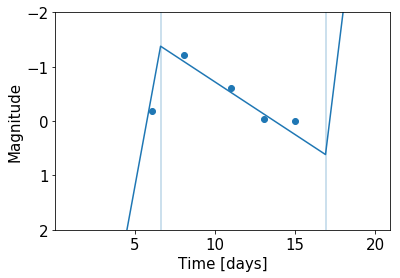

In [16]:
bestfit=[f[0] for f in fit]
bestfit

x_plt = np.arange(1,20,0.01)
plt.plot(x_plt, np.array([model(bestfit, v, r1=True) for v in x_plt]))
plt.scatter(x,y)
plt.axvline(bestfit[-3],alpha=0.3)
plt.axvline(bestfit[-2],alpha=0.3)
plt.gca().invert_yaxis()
plt.ylim(2, -2)
plt.xlabel('Time [days]')
plt.ylabel('Magnitude')
# plt.title('22jpx_r')
# plt.savefig('./figures/22jpx_r_mcmc_3line.png')

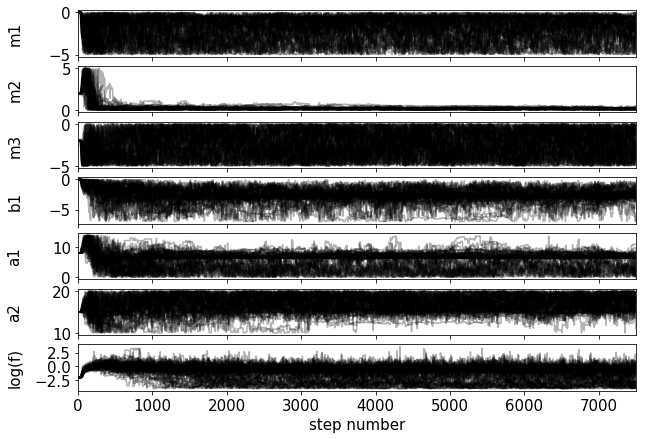

In [17]:
samples = mc.get_chain()

# # if r1
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
labels = ["m1","m2","m3","b1","a1","a2","log(f)"]

# # if no r1
# fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
# labels = ["m2","m3","b2","a1","a2","log(f)"]

for i in range(7): #6 no r1, 7 if r1
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# plt.savefig('./figures/22jpx_r_mcmc_3line_walkers.png')

(31552, 7)


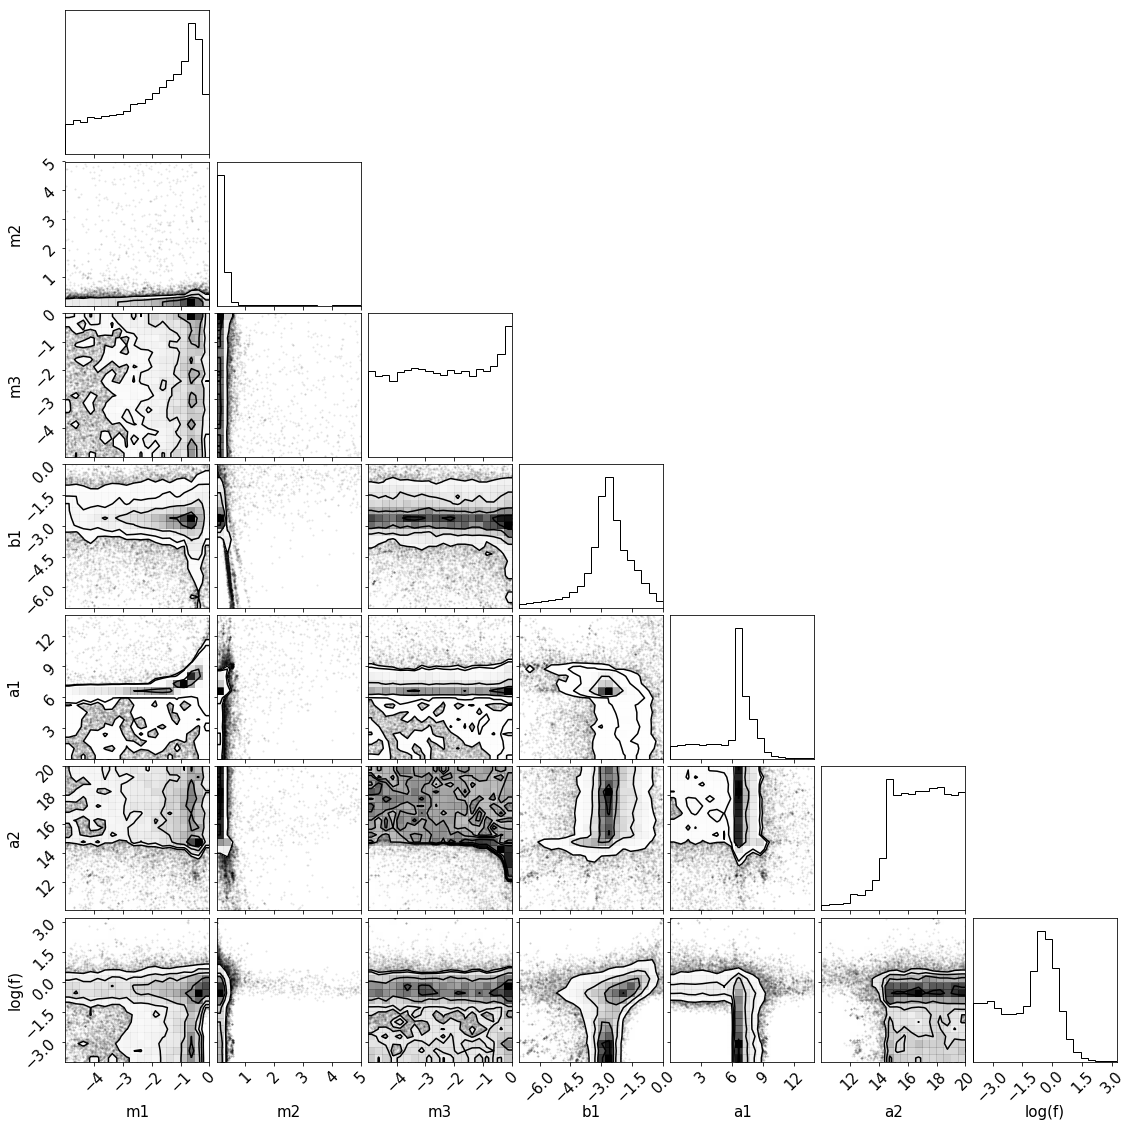

In [18]:
labels = ["m1","m2","m3","b1","a1","a2","log(f)"]
# labels = ["m2","m3","b2","a1","a2","log(f)"]

flat_samples = mc.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

# plt.savefig('./figures/22jpx_r_mcmc_3line_corner.png')

In [19]:
bestfit=[f[0] for f in fit]
bestfit

[-1.6103248502171241,
 0.19367255766803534,
 -2.390470209415817,
 -2.6576091141952087,
 6.608434958852959,
 16.900433601641474,
 -0.9002312808215869]